# rs_embed Playground

This notebook demonstrates **direct usage of `get_embedding`** from `rs_embed`,
without any wrapper utilities.

The goal is to clearly expose the **core toolkit API**:
- spatial inputs (`PointBuffer`, `BBox`)
- temporal specs (`year`, `range`)
- output specs (`pooled`, `grid`)
- returned `data` and `meta`

This is intended as a **transparent, reference-style notebook** rather than a benchmarking framework.


In [1]:
from rs_embed import BBox, PointBuffer, TemporalSpec, OutputSpec, get_embedding
from plot_utils import *

import json

## 1. Define spatial and temporal inputs

In [20]:
# Spatial: point + buffer
spatial_point = PointBuffer(
    lon=121.5,
    lat=31.2,
    buffer_m=2048,
)

# Spatial: bounding box
spatial_bbox = BBox(
    minlon=121.45,
    minlat=31.15,
    maxlon=121.50,
    maxlat=31.20,
)

# Temporal: single year
temporal_year = TemporalSpec.year(2024)

# Temporal: date range
temporal_range = TemporalSpec.range(
    "2022-06-01",
    "2022-09-01",
)

spatial_point, spatial_bbox, temporal_year, temporal_range

(PointBuffer(lon=121.5, lat=31.2, buffer_m=2048, crs='EPSG:4326'),
 BBox(minlon=121.45, minlat=31.15, maxlon=121.5, maxlat=31.2, crs='EPSG:4326'),
 TemporalSpec(mode='year', year=2024, start=None, end=None),
 TemporalSpec(mode='range', year=<function TemporalSpec.year at 0x14929f836b60>, start='2022-06-01', end='2022-09-01'))

## 2. Precomputed embedding example (`gse_annual`)

- Spatial: `BBox`
- Temporal: `year`
- Output: `grid`


{'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[13523270.13138274, 3656702.2802829933], [13527366.13138274, 3656702.2802829933], [13527366.13138274, 3660798.2802829933], [13523270.13138274, 3660798.2802829933], [13523270.13138274, 3656702.2802829933]]]}
data.shape: (64, 410, 410)
source: GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL


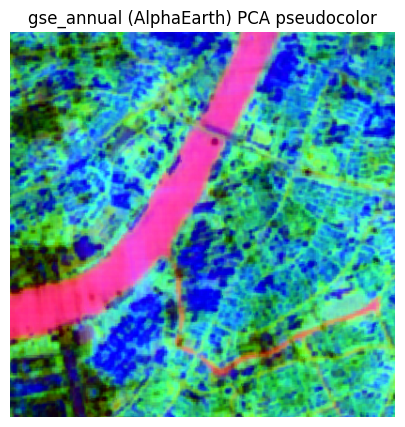

{'mean': array([ 0.07853824, -0.29107493,  0.1161385 , -0.01957924,  0.02499747,
        -0.07961908, -0.09171757, -0.04517604, -0.16079898,  0.08444491,
         0.04607062,  0.04059851, -0.15324387, -0.15063843, -0.11724014,
        -0.11368866,  0.08037771,  0.14151959, -0.07956102,  0.07384185,
        -0.04462529,  0.10088068, -0.10032278,  0.01416243, -0.05940819,
         0.23154068,  0.00040225, -0.0277066 ,  0.15224236,  0.0368964 ,
         0.0367008 ,  0.01560507, -0.07904538, -0.04380777,  0.11977525,
        -0.0081563 , -0.20165128, -0.06312177,  0.05876789,  0.02970741,
        -0.07101694, -0.02973392, -0.0059794 ,  0.04876955,  0.10008385,
         0.16855767, -0.06602319,  0.15204938,  0.12364287,  0.04426003,
        -0.08971214,  0.09532284, -0.1818591 ,  0.07876746,  0.19386826,
        -0.28169596,  0.03485641,  0.04957942,  0.03513833,  0.01825983,
        -0.02705266, -0.13622743, -0.08715788,  0.07614619], dtype=float32),
 'components': array([[-1.00033954e-01,

<Figure size 640x480 with 0 Axes>

In [9]:
emb = get_embedding(
    "gse_annual",
    spatial=spatial_point,
    temporal=temporal_year,
    output=OutputSpec.grid(scale_m=10),
)

print("data.shape:", emb.data.shape)
print("source:", emb.meta.get("source"))

plot_embedding_pseudocolor(
    emb,
    title="gse_annual (AlphaEarth) PCA pseudocolor",
)

## 3. On-the-fly model: `remoteclip_s2rgb`

### 3.1 Pooled output
- Spatial: `PointBuffer`
- Temporal: date range
- Output: `pooled(mean)`


In [5]:
emb_remoteclip_pooled = get_embedding(
    "remoteclip_s2rgb",
    spatial=spatial_point,
    temporal=temporal_range,
    output=OutputSpec.pooled(pooling="mean"),
)

print("data.shape:", emb_remoteclip_pooled.data.shape)
print("model:", emb_remoteclip_pooled.meta.get("model"))

print(json.dumps(emb_remoteclip_pooled.meta, indent=2)[:1500])

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights from local directory
data.shape: (768,)
model: remoteclip_s2rgb
{
  "model": "remoteclip_s2rgb",
  "type": "on_the_fly",
  "backend": "gee",
  "source": "COPERNICUS/S2_SR_HARMONIZED",
  "sensor": {
    "collection": "COPERNICUS/S2_SR_HARMONIZED",
    "bands": [
      "B4",
      "B3",
      "B2"
    ],
    "scale_m": 10,
    "cloudy_pct": 30,
    "composite": "median"
  },
  "temporal": {
    "mode": "range",
    "start": "2022-06-01",
    "end": "2022-09-01"
  },
  "input_time": "2022-07-17",
  "image_size": 224,
  "bands": [
    "B4",
    "B3",
    "B2"
  ],
  "scale_m": 10,
  "cloudy_pct": 30,
  "composite": "median",
  "start": "2022-06-01",
  "end": "2022-09-01",
  "ckpt": "MVRL/remote-clip-vit-base-patch32",
  "device": "auto",
  "pretrained_required": true,
  "auto_download": true,
  "hf_cache_dir": null,
  "ckpt_input": "MVRL/remote-clip-vit-base-patch32",
  "ckpt_local_dir": "/u/dingqi2/.cache/huggingface/hub/models--MVRL--remote-clip-vit-base-patch32/snapshots

### 3.2 Grid output

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights from local directory
data.shape: (768, 7, 7)
grid_hw: (7, 7)


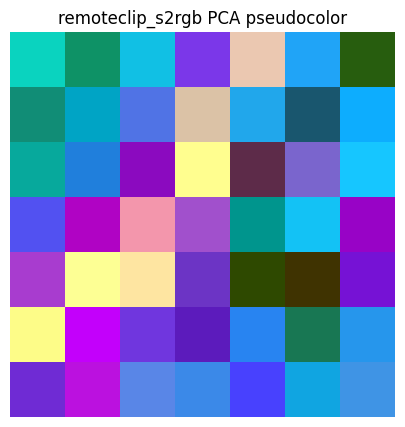

{'mean': array([-1.76906977e-02,  2.06798911e-01,  2.73429662e-01, -6.53784752e-01,
         6.10044062e-01, -8.09943557e-01,  6.67615160e-02, -3.52510810e-02,
        -1.79212436e-01, -1.80408806e-01, -3.89561802e-02,  5.67845702e-02,
         7.16561899e-02,  1.42418489e-01,  2.71564484e-01,  2.52629161e-01,
         5.96774578e-01, -2.27199662e-02, -1.01229660e-01,  1.30110338e-01,
        -1.21245250e-01, -2.17262626e-01, -2.87321925e-01,  2.59204894e-01,
        -3.17568094e-01,  7.02984706e-02, -1.82314496e-02,  2.72616625e-01,
         4.24753487e-01, -2.15760022e-01, -5.07746100e-01, -3.46954197e-01,
         1.86455011e-01,  9.60011408e-02,  1.97194085e-01,  1.94297552e-01,
        -2.10368648e-01,  5.18119812e-01,  4.66237329e-02, -2.38009810e-01,
         7.73941875e-01, -1.80109680e-01,  9.09734964e-02,  5.31410687e-02,
        -5.63504279e-01, -4.46667075e-01, -2.64440894e-01, -3.32388341e-01,
         2.62018740e-01,  2.16017276e-01,  1.84968486e-01,  3.50484729e-01,
    

<Figure size 640x480 with 0 Axes>

In [6]:
emb_remoteclip_grid = get_embedding(
    "remoteclip_s2rgb",
    spatial=spatial_point,
    temporal=temporal_range,
    output=OutputSpec.grid(),
)

print("data.shape:", emb_remoteclip_grid.data.shape)
print("grid_hw:", emb_remoteclip_grid.meta.get("grid_hw"))

plot_embedding_pseudocolor(
    emb_remoteclip_grid,
    title="remoteclip_s2rgb PCA pseudocolor",
)

## 4. `tessera` examples

### 4.1 Grid output (BBox, local backend)


data.shape: (128, 549, 485)
meta keys: ['model', 'type', 'source', 'cache_dir', 'bbox_4326', 'preferred_year', 'chw_shape', 'tile_crs', 'mosaic_hw', 'crop_px_window', 'crop_hw', 'global_transform']


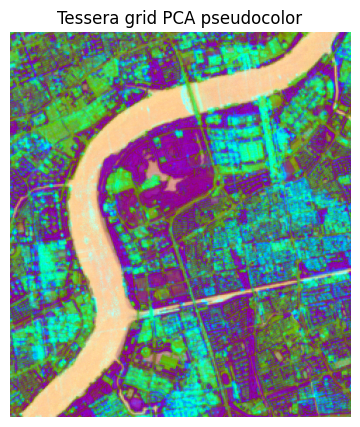

{'mean': array([ 2.7710488 , -3.1914015 , -1.5731486 ,  4.2386165 , -1.064906  ,
        -1.4422755 , -1.4102966 , -1.256325  , -0.25890803,  1.9263722 ,
         0.31182835,  2.8367252 ,  1.2041409 , -3.2217062 , -2.0482264 ,
         0.6465328 , -0.31048298,  2.6354065 , -0.11700071,  1.6563276 ,
         2.4264867 ,  2.0352023 ,  1.9718763 , -1.4658926 ,  4.5324316 ,
         1.0120744 , -1.5957816 ,  2.663834  , -1.7194703 ,  3.2779913 ,
        -1.9778243 ,  2.626533  , -2.1938543 ,  0.70385814,  1.6396428 ,
        -0.33020929,  3.160933  ,  0.41201878,  0.7033538 , -0.6141192 ,
         0.3612991 , -1.9407953 ,  1.9511636 ,  2.664025  ,  0.5771154 ,
         0.39909297,  0.12937924, -2.2028968 ,  2.6420612 , -4.047062  ,
        -3.0035453 , -1.0439631 , -2.7931485 , -3.0180223 ,  2.9727561 ,
         2.9256961 ,  0.87446415, -0.06245363,  3.6664984 ,  1.6580267 ,
         2.218993  ,  0.24016571,  3.2763329 ,  3.704354  ,  1.7669511 ,
         0.553271  , -0.92319953, -1.365413

<Figure size 640x480 with 0 Axes>

In [21]:
emb_tessera_grid = get_embedding(
    "tessera",
    spatial=spatial_bbox,
    temporal=temporal_year,
    output=OutputSpec.grid(),
    backend="local",
)

print("data.shape:", emb_tessera_grid.data.shape)
print("meta keys:", list(emb_tessera_grid.meta.keys()))

plot_embedding_pseudocolor(
    emb_tessera_grid,
    title="Tessera grid PCA pseudocolor",
)

### 4.2 Pooled output (PointBuffer)

In [22]:
emb_tessera_pooled = get_embedding(
    "tessera",
    spatial=spatial_point,
    temporal=temporal_year,
    output=OutputSpec.pooled(),
    backend="local",
)

print("data.shape:", emb_tessera_pooled.data.shape)
print("dim:", emb_tessera_pooled.meta.get("dim"))

data.shape: (128,)
dim: None


## 5. `copernicus_embed` (local backend)

100%|██████████| 768M/768M [00:01<00:00, 434MB/s] 


data.shape: (768, 4, 4)


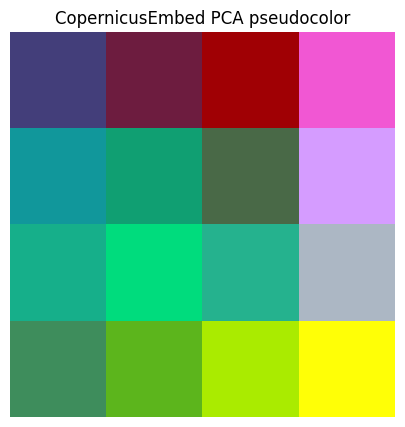

{'mean': array([-6.62231326e-01, -1.02608874e-01,  3.25848490e-01,  5.33732951e-01,
         5.20238400e-01, -7.37616301e-01,  9.10163403e-01,  3.36435020e-01,
        -4.58203018e-01, -4.28563833e-01,  2.32327342e-01, -1.28065872e+00,
         3.75901759e-01, -4.54569548e-01, -1.14987993e+00,  2.26949692e-01,
         1.10320997e+00,  3.38927060e-01, -2.39709556e-01,  5.63005172e-02,
         3.63123834e-01, -9.50055793e-02,  3.45632374e-01, -8.09691525e+00,
        -6.29177392e-02, -4.62233603e-01, -9.50398743e-02,  1.34505764e-01,
        -1.30617142e+01, -2.48391658e-01,  1.01915765e+00, -7.46000051e-01,
         5.34739017e-01,  5.96139848e-01,  2.76985645e-01,  4.15814549e-01,
        -6.06991768e-01,  6.69056058e-01, -1.00135303e+00, -3.23049098e-01,
         3.40744197e-01, -1.62872970e-02, -3.48878503e-01, -5.31999350e-01,
        -2.50054523e-04,  3.62773716e-01, -4.95694503e-02,  3.08843732e-01,
         4.58715409e-02, -1.34331718e-01, -1.79159820e-01,  9.89699543e-01,
    

<Figure size 640x480 with 0 Axes>

In [11]:
temporal_year = TemporalSpec.year(2021)
emb_cop_grid = get_embedding(
    "copernicus_embed",
    spatial=spatial_point,
    temporal=temporal_year,
    output=OutputSpec.grid(),
    backend="local",
)

print("data.shape:", emb_cop_grid.data.shape)

plot_embedding_pseudocolor(
    emb_cop_grid,
    title="CopernicusEmbed PCA pseudocolor",
)

## 6. Get Embedding Batches

In [24]:
from rs_embed import BBox, get_embeddings_batch

points = [
    PointBuffer(lon=121.5, lat=31.2, buffer_m=100),
    PointBuffer(lon=121.6, lat=31.3, buffer_m=100),
    PointBuffer(lon=120.0, lat=30.0, buffer_m=100),
]

embeddings = get_embeddings_batch(
    "dofa",
    spatials=points,
    temporal=TemporalSpec.range("2021-06-01", "2021-08-31"),
    backend="gee"
)

for i, emb in enumerate(embeddings):
    print(f"Embedding {i} shape: {emb.data.shape}")


Embedding 0 shape: (768,)
Embedding 1 shape: (768,)
Embedding 2 shape: (768,)


## 7. Data quality and visualization inspection (`inspect_gee_patch`)
- Use the Sentinel-2 SR RGB sample for quicklook. First, check the input data, then run the embedding.
- After running, the quicklook will be saved in the `_gee_checks/` directory and a statistical/histogram preview will be printed.

In [13]:
from pathlib import Path
import os

from rs_embed import SensorSpec, inspect_gee_patch

save_dir = Path(os.getenv("RS_EMBED_CHECK_SAVE_DIR", "./_gee_checks")).resolve()
save_dir.mkdir(parents=True, exist_ok=True)

sensor = SensorSpec(
    collection="COPERNICUS/S2_SR_HARMONIZED",
    bands=("B4", "B3", "B2"),
    scale_m=10,
    cloudy_pct=10,
    composite="median",
    fill_value=0.0,
    check_save_dir=str(save_dir),
)

check_out = inspect_gee_patch(
    spatial=spatial_point,
    temporal=TemporalSpec.range("2022-06-01", "2022-09-01"),
    sensor=sensor,
    value_range=(0, 10000),
)

print("ok:", check_out.get("ok"))
report = check_out.get("report", {})
for key in ["shape", "dtype", "nan_frac", "inf_frac", "fill_frac", "const_frac"]:
    if key in report:
        print(f"{key}: {report[key]}")



ok: True
shape: (3, 410, 410)
dtype: float32
fill_frac: 0.009030339083878644


band_quantiles (first 3 bands):
{
  "p01": [
    112.0,
    237.0,
    0.0
  ],
  "p50": [
    1064.0,
    1034.0,
    756.0
  ],
  "p99": [
    5128.0,
    5068.0,
    4896.0
  ]
}


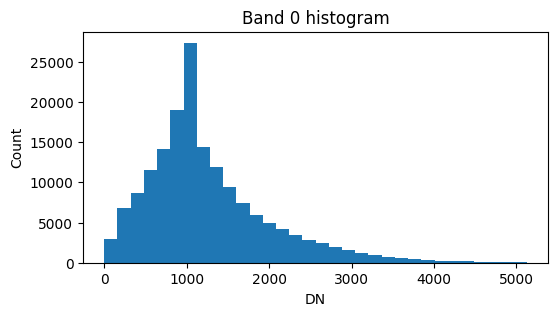

In [14]:
band_q = report.get("band_quantiles")
if band_q:
    preview = {k: v[:3] for k, v in band_q.items()}
    print("band_quantiles (first 3 bands):")
    print(json.dumps(preview, indent=2))

hist = report.get("hist")
if hist and hist.get("bins") and hist.get("counts"):
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        plt = None
    if plt:
        bins = hist["bins"]
        counts = hist["counts"][0]
        plt.figure(figsize=(6, 3))
        plt.bar(bins[:-1], counts, width=bins[1] - bins[0], align="edge")
        plt.title("Band 0 histogram")
        plt.xlabel("DN")
        plt.ylabel("Count")
        plt.show()
    else:
        print("matplotlib not available, skip histogram plot")
else:
    print("histogram not available")




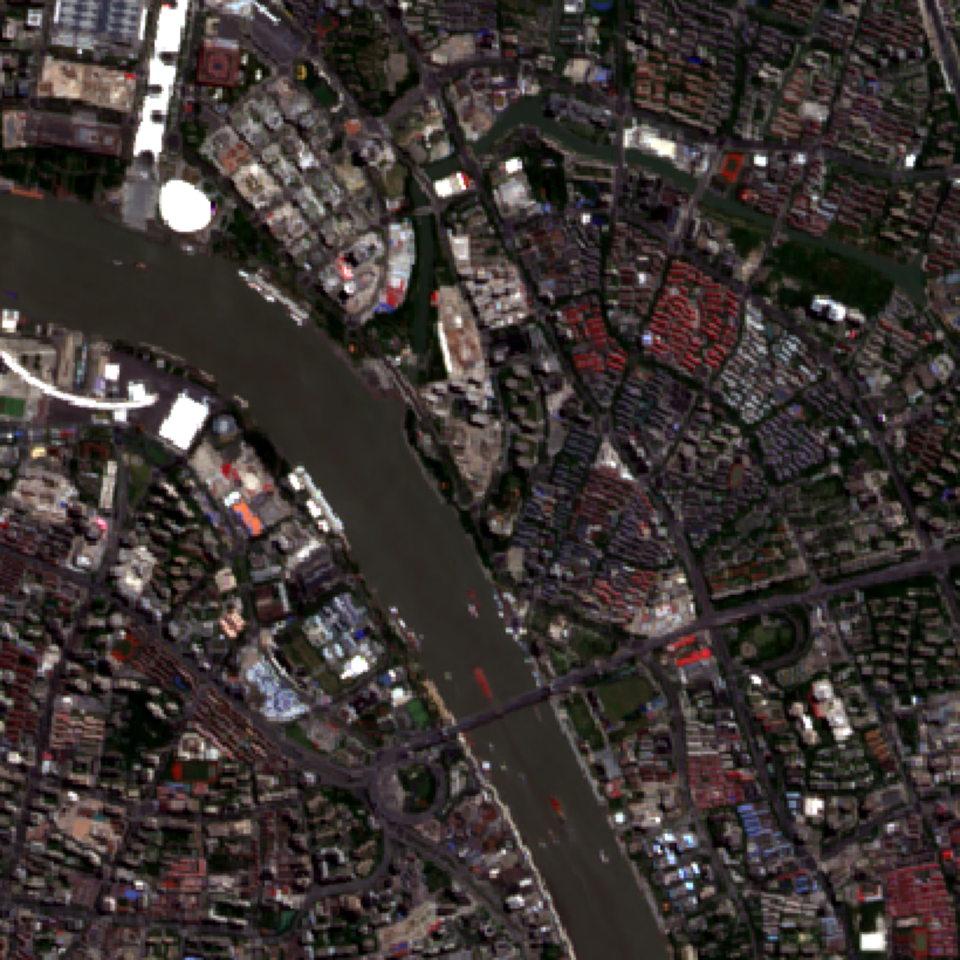

In [18]:
artifacts = check_out.get("artifacts") or {}
quicklook_path = artifacts.get("quicklook_rgb")
if quicklook_path and Path(quicklook_path).exists():
    from IPython.display import Image
    display(Image(filename=quicklook_path))
else:
    print("quicklook not saved; artifacts:", artifacts)

In [ ]:

from rs_embed import PointBuffer, TemporalSpec, OutputSpec
from rs_embed.export import export_npz

points = [
    ("p1", PointBuffer(lon=120.10, lat=30.20, buffer_m=256)),
    ("p2", PointBuffer(lon=120.30, lat=30.10, buffer_m=256)),
]

for name, spatial in points:
    export_npz(
        out_path=f"exports/{name}_2022_summer.npz",
        models=["remoteclip_s2rgb", "prithvi_eo_v2_s2_6b"],
        spatial=spatial,
        temporal=TemporalSpec.range("2022-06-01", "2022-09-01"),
        output=OutputSpec.pooled(),
        backend="gee",
        device="auto",
        save_inputs=True,
        save_embeddings=True,
        save_manifest=True,
    )

## Inspect exported NPZ + visualize input patches

This notebook cell loads:
- `p1_2022_summer.json` (manifest)
- `p1_2022_summer.npz` (arrays)

It prints a summary and visualizes the saved input patches (`input_chw__*`).
RGB inputs are shown with a per-channel percentile stretch.

=== Manifest summary ===
npz_path: ../exports/p1_2022_summer.npz
models: [{'model': 'remoteclip_s2rgb', 'sensor': {'collection': 'COPERNICUS/S2_SR_HARMONIZED', 'bands': ['B4', 'B3', 'B2'], 'scale_m': 10, 'cloudy_pct': 30, 'fill_value': 0.0, 'composite': 'median', 'check_input': False, 'check_raise': True, 'check_save_dir': None}, 'input': {'npz_key': 'input_chw__remoteclip_s2rgb', 'dtype': 'float32', 'shape': [3, 52, 52], 'sha1': 'd2cd7247fa0ad552874bbc993d11e0d64aea430f', 'inspection': {'ok': True, 'report': {'name': 'input_remoteclip_s2rgb', 'ok': True, 'issues': [], 'shape': [3, 52, 52], 'dtype': 'float32', 'finite_frac': 1.0, 'band_min': [228.0, 354.0, 274.0], 'band_max': [836.0, 874.0, 580.0], 'band_mean': [317.3842468261719, 497.5469665527344, 351.1002197265625], 'band_std': [53.17584991455078, 52.97297286987305, 31.056291580200195], 'band_quantiles': {'p01': [251.0, 397.0, 291.03], 'p50': [310.0, 493.0, 349.0], 'p99': [570.0, 660.9699999999998, 461.8799999999992]}, 'hist': {'bin

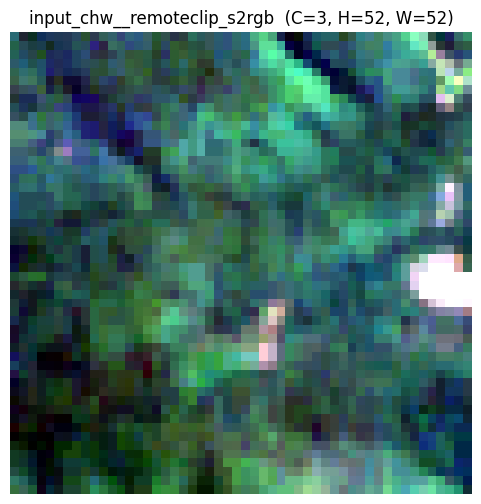

input_chw__prithvi_eo_v2_s2_6b           shape=(6, 52, 52) dtype=float32 min=228 max=5e+03


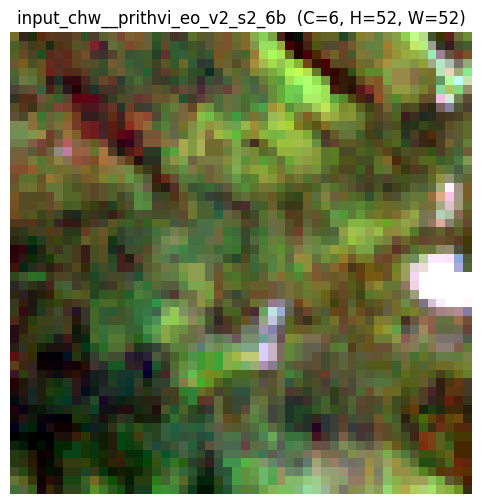

In [26]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt


# ==== 1) paths ====
npz_path = Path("../exports/p1_2022_summer.npz")
json_path = Path("../exports/p1_2022_summer.json")

assert npz_path.exists(), f"Missing: {npz_path}"
assert json_path.exists(), f"Missing: {json_path}"


# ==== 2) load ====
z = np.load(npz_path)
with open(json_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

print("=== Manifest summary ===")
print("npz_path:", manifest.get("npz_path", str(npz_path)))
print("models:", manifest.get("models"))
print("spatial:", manifest.get("spatial"))
print("temporal:", manifest.get("temporal"))
print("backend:", manifest.get("backend"))
print("npz_keys:", manifest.get("npz_keys", z.files))

print("\n=== NPZ keys ===")
print(z.files)


# ==== 3) helpers ====
def percentile_stretch(rgb_hwc: np.ndarray, p_low=1.0, p_high=99.0, gamma=1.0) -> np.ndarray:
    """Per-channel percentile stretch to [0,1]."""
    rgb = rgb_hwc.astype(np.float32)
    rgb = np.nan_to_num(rgb, nan=0.0, posinf=0.0, neginf=0.0)

    out = np.empty_like(rgb)
    for c in range(3):
        lo = np.percentile(rgb[..., c], p_low)
        hi = np.percentile(rgb[..., c], p_high)
        if hi <= lo + 1e-6:
            out[..., c] = 0.0
        else:
            out[..., c] = (rgb[..., c] - lo) / (hi - lo)
    out = np.clip(out, 0.0, 1.0)
    if gamma != 1.0:
        out = out ** (1.0 / gamma)
    return out


def show_input_chw(x_chw: np.ndarray, title: str, rgb_idx=(0, 1, 2), p_low=1, p_high=99):
    """Visualize CHW input. If C>=3 show RGB via indices; else show grayscale."""
    if x_chw.ndim != 3:
        print(f"Skip {title}: expected CHW, got shape={x_chw.shape}")
        return

    c, h, w = x_chw.shape
    print(f"{title:40s} shape={x_chw.shape} dtype={x_chw.dtype} min={x_chw.min():.3g} max={x_chw.max():.3g}")

    plt.figure(figsize=(6, 6))
    if c >= 3:
        r, g, b = rgb_idx
        if max(rgb_idx) >= c:
            raise ValueError(f"rgb_idx={rgb_idx} out of range for C={c}")

        rgb = np.stack([x_chw[r], x_chw[g], x_chw[b]], axis=-1)  # HWC
        rgb = percentile_stretch(rgb, p_low=p_low, p_high=p_high, gamma=1.0)
        plt.imshow(rgb)
    else:
        plt.imshow(x_chw[0], cmap="gray")

    plt.title(f"{title}  (C={c}, H={h}, W={w})")
    plt.axis("off")
    plt.show()


# ==== 4) visualize all inputs ====
input_keys = [k for k in z.files if k.startswith("input_chw__")]
if not input_keys:
    print("No input_chw__* keys found. Keys:", z.files)
else:
    print("\n=== Visualizing inputs ===")
    for k in input_keys:
        show_input_chw(z[k], title=k, rgb_idx=(0, 1, 2), p_low=1, p_high=99)


# ==== 5) show artifacts (quicklook paths etc.) if any ====
artifacts = manifest.get("artifacts") or {}
if artifacts:
    print("\n=== Artifacts ===")
    print(json.dumps(artifacts, ensure_ascii=False, indent=2))

In [ ]:
model_id = "remoteclip_s2rgb"
k = f"input_chw__{model_id}"
assert k in z.files, f"Missing key: {k}. Available: {z.files}"
show_input_chw(z[k], title=k, rgb_idx=(0,1,2), p_low=1, p_high=99)

## 7. Notes

- All examples above use **direct `get_embedding` calls**.
- This notebook intentionally avoids helper wrappers to keep the API explicit.
- For new models, copy an existing cell and modify:
  - `model name`
  - `spatial`
  - `temporal`
  - `OutputSpec`
